## Step 0: Understand the Data
Get the info of errors and missing values

In [8]:
import pandas as pd
import numpy as np
s = pd.read_csv("Public_School_Characteristics_2022-23.csv")
s_b = s.copy()
s.shape

C:\Users\mktmo\AppData\Local\Temp\ipykernel_32136\1985055591.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  s = pd.read_csv("Public_School_Characteristics_2022-23.csv")


(101390, 77)

### Pattern for each column
TOTAL = TOTMENROL + TOTFENROL
TOTAL = PK + KG + G01 + G02 + G03 + G04 + G05
      + G06 + G07 + G08
      + G09 + G10 + G11 + G12
      + UG + AE
      
TOTAL = AM + AS + HI + BL + WH + HP + TR

Lunch:
TOTFRL = FRELCH + REDLCH

STUTERATIO = TOTAL / FTE

Elementary Schools:
G09 + G10 + G11 + G12 ≈ 0

High Schools:
PK + KG + G01–G08 ≈ 0

AMALM + AMALF = AM

ASALM + ASALF = AS

BLALM + BLALF = BL

HPALM + HPALF = HP

HIALM + HIALF = HI

TRALM + TRALF = TR

WHALM + WHALF = WH

### Missing Value info

In [9]:
special_values = [-1, -2, -9, "M", "N"]
s = s.replace(r'^\s*$', np.nan, regex=True) # Find any string that is completely empty ('') or only spaces (' '), replace it with np.nan

rows_with_special = s.isin(special_values).any(axis=1).sum()
print("Rows with special values: ",rows_with_special)
rows_with_missing_value = s.isna().any(axis=1).sum()
print("total rows with missing values: ",rows_with_missing_value)
total_missing = s.isna().sum().sum()
print("total missing values: ",total_missing)

Rows with special values:  62134
total rows with missing values:  101390
total missing values:  1352278


## Step 1: Data Cleaning
### 1.1 Handling missing 0's for Students Each Grade

In [10]:

cols = s.loc[:, 'PK':'AE'].columns  # all columns from PK to AE

# 1️⃣ Row-wise sum of PK to AE (ignores NaN by default)
row_sum = s[cols].sum(axis=1)

# 2️⃣ Find rows where sum equals TOTAL
mask = row_sum.eq(s['TOTAL'])

# 3️⃣ Fill NaN with 0 only for those rows
s.loc[mask, cols] = s.loc[mask, cols].fillna(0)
print("Rows with special values: ", s.isin(special_values).any(axis=1).sum())
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())

Rows with special values:  62134
total rows with missing values:  101244
total missing values:  238819


### 2.2 Removing Redundant Rows and Features

#### Dropping Rows and Features with Too less value

In [11]:
# reference for rows missing value threshold
s_b.loc[49:55,:].isna().mean(axis=1)

49    0.181818
50    0.571429
51    0.571429
52    0.571429
53    0.571429
54    0.571429
55    0.571429
dtype: float64

In [12]:
s = s[s.isna().mean(axis=1) <= 0.55]
print("Rows with special values: ", s.isin(special_values).any(axis=1).sum())
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))

Rows with special values:  60467
total rows with missing values:  99577
total missing values:  164969
LSTREET2      99215
LZIP4         41866
FTE            2565
STUTERATIO     1814
HPALM           941
HPALF           940
AMALM           914
AMALF           912
HP              894
AM              866
BLALF           830
BLALM           827
ASALM           825
ASALF           823
BL              820
TRALM           820
TRALF           818
TR              817
AS              817
WHALM           814
HIALM           814
WHALF           814
HIALF           813
TOTFENROL       813
TOTMENROL       813
WH              813
HI              813
G13               9
UG                9
AE                9
G12               8
G11               8
G10               8
G09               8
G07               7
PK                7
G08               7
G06               7
G05               7
G04               7
G03               7
G02               7
G01               7
KG                7
MEMBER            

In [13]:
# drop columns that have missing value with 40%
cols_dropped_40 = s.columns[s.isna().mean() > 0.40]
print("column dropped: ", cols_dropped_40.tolist())
s = s.loc[:, s.isna().mean() <= 0.40]
print("Rows with special values: ", s.isin(special_values).any(axis=1).sum())
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))

column dropped:  ['LSTREET2', 'LZIP4']
Rows with special values:  60467
total rows with missing values:  5403
total missing values:  23888
FTE           2565
STUTERATIO    1814
HPALM          941
HPALF          940
AMALM          914
AMALF          912
HP             894
AM             866
BLALF          830
BLALM          827
ASALM          825
ASALF          823
BL             820
TRALM          820
TRALF          818
AS             817
TR             817
WHALM          814
WHALF          814
HIALM          814
TOTFENROL      813
HIALF          813
HI             813
TOTMENROL      813
WH             813
G13              9
UG               9
AE               9
G12              8
G09              8
G10              8
G11              8
G07              7
KG               7
G01              7
G02              7
G03              7
G04              7
G05              7
G06              7
PK               7
G08              7
TOTAL            4
MEMBER           4
LSTREET1         1
LATCOD

### 2.3 Imputate Continuous Values

In [14]:
# NCES placeholder codes (-1, -2, -9) are non observations (missing / not applicable / low quality),
# so they shouldn't be used as real numeric values in statistics and be replaced.

placeholder_codes = [-1, -2, -9, "M", "N"]

# Replace placeholder codes with NaN (only for columns where codes appear)
for c in ["STUTERATIO", "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT", "CHARTER_TEXT"]:
    if c in s.columns:
        s[c] = s[c].replace(placeholder_codes, np.nan)

# Ensure numeric columns are numeric
numeric_fix_cols = [
    "TOTAL", "FTE", "STUTERATIO",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT"
]
for c in numeric_fix_cols:
    if c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")

print("Missing counts (after placeholder -> NaN):")
print(s[numeric_fix_cols].isna().sum().sort_values(ascending=False))

# TOTAL: If TOTAL is missing, rebuild from grade level columns (PK to AE) when possible.
grade_cols = [c for c in s.columns if c in list(s.loc[:, "PK":"AE"].columns)]
if "TOTAL" in s.columns and grade_cols:
    total_from_grades = s[grade_cols].sum(axis=1, min_count=1)
    missing_total = s["TOTAL"].isna()
    s.loc[missing_total, "TOTAL"] = total_from_grades[missing_total]
    print("Filled TOTAL from grade sums:", int(missing_total.sum()))

# STUTERATIO: If missing, compute using TOTAL and FTE when both exist.
# First, we check that the relationship holds for most records.
if "TOTAL" in s.columns and "FTE" in s.columns and "STUTERATIO" in s.columns:
    s["RATIO_FROM_TOTAL_FTE"] = s["TOTAL"] / s["FTE"]
    s.loc[s["FTE"] == 0, "RATIO_FROM_TOTAL_FTE"] = None
    temp = s.dropna(subset=["STUTERATIO", "RATIO_FROM_TOTAL_FTE"])
    temp["ABS_DIFF"] = (temp["STUTERATIO"] - temp["RATIO_FROM_TOTAL_FTE"]).abs()
    print("mean abs diff =", round(float(temp["ABS_DIFF"].mean()), 4))
    before = s["STUTERATIO"].isna().sum()
    s.loc[s["STUTERATIO"].isna(), "STUTERATIO"] = s["RATIO_FROM_TOTAL_FTE"]
    after = s["STUTERATIO"].isna().sum()
    print("Filled STUTERATIO values:", int(before - after))
    s = s.drop(columns=["RATIO_FROM_TOTAL_FTE"], errors="ignore")
# To verify consistency internally, we compared the STUTERATIO to the computed value TOTAL/FTE. 
# We calculated the mean absolute difference to measure the avg deviation between the two values. 
# A small mean absolute difference shows that the ratios are consistent with actual enrollment and teacher counts.

# FTE: If missing, compute using TOTAL / STUTERATIO.
if "TOTAL" in s.columns and "FTE" in s.columns and "STUTERATIO" in s.columns:
    s["FTE_FROM_RATIO"] = s["TOTAL"] / s["STUTERATIO"]
    s.loc[s["STUTERATIO"] == 0, "FTE_FROM_RATIO"] = None
    before = s["FTE"].isna().sum()
    s.loc[s["FTE"].isna(), "FTE"] = s["FTE_FROM_RATIO"]
    after = s["FTE"].isna().sum()
    print("Filled FTE values:", int(before - after))
    s = s.drop(columns=["FTE_FROM_RATIO"], errors="ignore")

# Remaining missing in continuous columns: use group wise median since less sensitive to outliers
# Group by SCHOOL_LEVEL and STABR if available because school staffing and enrollment patterns are different depending on level and state.
for c in ["STUTERATIO", "FTE"]:
    if c in s.columns:
        # If both grouping columns exist, fill by SCHOOL_LEVEL and STABR
        if "SCHOOL_LEVEL" in s.columns and "STABR" in s.columns:
            for level in s["SCHOOL_LEVEL"].dropna().unique():
                for state in s["STABR"].dropna().unique():
                    # rows in this level and this state
                    condition = (s["SCHOOL_LEVEL"] == level) & (s["STABR"] == state)
                    group_values = s.loc[condition, c]
                    # calculate median if the group has at least one proper value
                    if group_values.notna().sum() > 0:
                        group_median = group_values.median()
                        # fill only missing values inside this group
                        s.loc[condition & s[c].isna(), c] = group_median
        # Otherwise, fill it with overall median
        else:
            overall_median = s[c].median()
            s.loc[s[c].isna(), c] = overall_median
# Remaining missing values in continuous variables (STUTERATIO and FTE) were imputed using group-wise median imputation. 
# Schools were grouped by SCHOOL_LEVEL and STABR because staffing and enrollment differ across different school types and states. 
# Median was chosen instead of mean to minimize sensitivity to extreme outliers in the enrollment and staffing counters. 
# This helps to uphold differences in the structure of the dataset but preventing too much data loss from deleting rows. 
# If grouping variables were unavailable, overall median imputation was used.

print("\nMissing counts after continuous imputations:")
print("Rows with special values: ", s.isin(special_values).any(axis=1).sum())
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))

Missing counts (after placeholder -> NaN):
DIRECTCERT    49548
FRELCH        18960
REDLCH        18960
TOTFRL        13098
STUTERATIO     4383
FTE            2565
TOTAL             4
dtype: int64
Filled TOTAL from grade sums: 4
mean abs diff = 0.0063
Filled STUTERATIO values: 0
Filled FTE values: 0


C:\Users\mktmo\AppData\Local\Temp\ipykernel_32136\3040304910.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["ABS_DIFF"] = (temp["STUTERATIO"] - temp["RATIO_FROM_TOTAL_FTE"]).abs()



Missing counts after continuous imputations:
Rows with special values:  0
total rows with missing values:  60871
total missing values:  123815
DIRECTCERT      49548
REDLCH          18960
FRELCH          18960
TOTFRL          13098
CHARTER_TEXT     3681
HPALM             941
HPALF             940
AMALM             914
AMALF             912
HP                894
AM                866
BLALF             830
BLALM             827
ASALM             825
ASALF             823
TRALM             820
BL                820
TRALF             818
TR                817
AS                817
HIALM             814
WHALF             814
WHALM             814
HI                813
HIALF             813
TOTMENROL         813
WH                813
TOTFENROL         813
STUTERATIO         55
AE                  9
UG                  9
G13                 9
G12                 8
G11                 8
G10                 8
G09                 8
G08                 7
G07                 7
G06                 

### 2.4 Imputate Discrete Values

In [15]:
import re

# Fix postal codes: if LZIP is numeric, leading zeros are lost in python. This converts them back to 5 character string.
if "LZIP" in s.columns:
    s["LZIP"] = s["LZIP"].astype("Int64").astype(str).str.zfill(5)

# Address field: if missing, fill with 'Unknown'
for c in ["LSTREET1", "PHONE"]:
    if c in s.columns:
        s[c] = s[c].fillna("Unknown")
# Missing values in categorical variables not included in the analysis such as street address and phone number were replaced 
# with the placeholder value "Unknown". These variables are descriptive identifiers and are not used for analysis. 
# Replacing missing values prevents needing to delete rows unnecessarily due to empty values and ensures consistency in the dataset.

# Free/Reduced lunch fields: these are count fields and can be 0 for schools with no participants.
# We used enrollment percentage as a consideration to avoid producing impossible counts.
if "TOTFRL" in s.columns and "TOTAL" in s.columns:
    # Create FRL_PCT (only when TOTAL > 0)
    s["FRL_PCT"] = s["TOTFRL"] / s["TOTAL"]
    s.loc[s["TOTAL"] == 0, "FRL_PCT"] = None
    # Fill missing FRL_PCT with overall median
    frl_median = s["FRL_PCT"].median()
    s.loc[s["FRL_PCT"].isna(), "FRL_PCT"] = frl_median
    # missing TOTFRL using FRL_PCT * TOTAL
    s.loc[s["TOTFRL"].isna(), "TOTFRL"] = (s["FRL_PCT"] * s["TOTAL"]).round()
    # keep TOTFRL within valid range [0, TOTAL]
    s.loc[s["TOTFRL"] < 0, "TOTFRL"] = 0
    s.loc[s["TOTFRL"] > s["TOTAL"], "TOTFRL"] = s["TOTAL"]
# if FRELCH and REDLCH exist, fill missing by splitting TOTFRL 50/50
if "FRELCH" in s.columns and "REDLCH" in s.columns and "TOTFRL" in s.columns:
    # If missing, assign half of TOTFRL to free lunch
    s.loc[s["FRELCH"].isna(), "FRELCH"] = (0.5 * s["TOTFRL"]).round()
    # Reduced lunch is whatever is left
    s.loc[s["REDLCH"].isna(), "REDLCH"] = (s["TOTFRL"] - s["FRELCH"]).round()
    # Prevent negatives
    s.loc[s["REDLCH"] < 0, "REDLCH"] = 0
# The Free/Reduced Lunch variables are count fields, so they must be not negative and not greater than total enrollment.
# To handle missing values first, we converted the total FRL count into a percentage of enrollment so that any imputed values 
# would scale properly with school size. Missing percentages were filled using the median to avoid being influenced by extreme values. 
# Then we rebuilt missing FRL counts using the percentage and total enrollment, rounding to keep whole numbers. 
# More checks made sure values stayed between 0 and total enrollment. When the free and reduced breakdown was missing,
# we used a 50/50 split to maintain consistency. These steps ensured logical modification while keeping as much data as possible.

# Ensure counts are non-negative
count_cols = ["TOTAL", "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT", "TOTMENROL", "TOTFENROL", "MEMBER"]

for c in count_cols:
    if c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")
        s.loc[s[c] < 0, c] = 0

print("Done discrete repairs. Remaining missing values:")
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))


Done discrete repairs. Remaining missing values:
total rows with missing values:  52562
total missing values:  72808
DIRECTCERT      49548
CHARTER_TEXT     3681
HPALM             941
HPALF             940
AMALM             914
AMALF             912
HP                894
AM                866
BLALF             830
BLALM             827
ASALM             825
ASALF             823
TRALM             820
BL                820
TRALF             818
TR                817
AS                817
HIALM             814
WHALM             814
WHALF             814
HIALF             813
TOTMENROL         813
HI                813
WH                813
TOTFENROL         813
STUTERATIO         55
G13                 9
UG                  9
AE                  9
G12                 8
G11                 8
G10                 8
G09                 8
PK                  7
G07                 7
G06                 7
G05                 7
G04                 7
G03                 7
G02                 7
G01

In [16]:
# Handling DIRECTCERT
## make sure to convert all to numeric
s['DIRECTCERT'] = pd.to_numeric(s['DIRECTCERT'], errors='coerce')
s['FRELCH'] = pd.to_numeric(s['FRELCH'], errors='coerce')

## FRELCH = Free lunch eligible, is high related to DIRECTCERT, so we use it to give an estimation of DIRECTCERT
## get the median ratio of "DIRECTVERT"/"FRELCH"
D_ratio = s['DIRECTCERT'] / s['FRELCH']
D_median_ratio = D_ratio[
    (s['DIRECTCERT'].notna()) & 
    (s['FRELCH'].notna()) &
    (s['FRELCH'] != 0)
].median()

## give missing value of missing DIRECTCERT only if FRELCH exists
D_mask = s['DIRECTCERT'].isna() & s['FRELCH'].notna()
s.loc[D_mask, 'DIRECTCERT'] = s.loc[D_mask, 'FRELCH'] * D_median_ratio

# Handling Constant columns: e.g. CHARTER_TEXT
## the value is mostly NO, so check the constant extent
from sklearn.feature_selection import VarianceThreshold
constant_threshold = 0.2
s['CHARTER_TEXT'] = s['CHARTER_TEXT'].map({
    'Yes': 1,
    'No': 0
})
num_df = s.select_dtypes(include='number')
selector = VarianceThreshold(constant_threshold)
selector.fit(num_df)
kept_cols = num_df.columns[selector.get_support()]
constant_cols = num_df.columns[~selector.get_support()]

print("Constant columns:", list(constant_cols))
# it's constant so will drop the feature at the step of handling constant feature
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))

Constant columns: ['CHARTER_TEXT', 'STATUS', 'FRL_PCT']
total rows with missing values:  4772
total missing values:  23264
CHARTER_TEXT    3681
HPALM            941
HPALF            940
AMALM            914
AMALF            912
HP               894
AM               866
BLALF            830
BLALM            827
ASALM            825
ASALF            823
TRALM            820
BL               820
TRALF            818
TR               817
AS               817
HIALM            814
WHALM            814
WHALF            814
HI               813
HIALF            813
TOTFENROL        813
TOTMENROL        813
WH               813
STUTERATIO        55
AE                 9
G13                9
UG                 9
G12                8
G11                8
G10                8
G09                8
G06                7
G07                7
G05                7
G04                7
G03                7
G02                7
G01                7
KG                 7
PK                 7
G08             

In [17]:
# Cleaning up the races value
# Goal: ensure totals are internally consistent and remove/repair impossible records.

race_cols = ["AM","AS","BL","HI","HP","TR","WH"]
race_cols = [c for c in race_cols if c in s.columns]

# Convert to numeric
for c in race_cols:
    s[c] = pd.to_numeric(s[c], errors="coerce")

# Race counts: if ALL race columns are missing, ethnicity composition cannot be computed.
# Since our problem statement uses ethnicity composition, we drop these rows.
all_race_missing = s[race_cols].isna().all(axis=1) if len(race_cols) > 0 else pd.Series(False, index=s.index)
print("Rows with all race counts missing:", int(all_race_missing.sum()))
s = s.loc[~all_race_missing].copy()

# If some race categories are missing but the known categories already sum to TOTAL, then missing categories must be 0.
if "TOTAL" in s.columns:

    race_sum_known = s[race_cols].sum(axis=1, min_count=1)

    # Loop through each row
    race_na_any = s[race_cols].isna().any(axis=1)
    for i in s.index:
        if (race_na_any.at[i] and pd.notna(s.at[i, "TOTAL"]) and race_sum_known.at[i] == s.at[i, "TOTAL"]):
            s.loc[i, race_cols] = s.loc[i, race_cols].fillna(0)

    # If exactly ONE race category is missing and TOTAL is known, fill the missing one as the remainder.
    missing_counts = s[race_cols].isna().sum(axis=1)
    one_missing = (missing_counts == 1) & s["TOTAL"].notna()
    remainder = s["TOTAL"] - s[race_cols].sum(axis=1, min_count=1)

    # Identify which column is missing per row and fill it
    for c in race_cols:
        mask = one_missing & s[c].isna() & (remainder >= 0)
        s.loc[mask, c] = remainder[mask]

    # Any remaining negative remainder means race totals exceed TOTAL (inconsistent).
    ##remainder_after = s["TOTAL"] - s[race_cols].sum(axis=1, min_count=1)
    ##inconsistent_race = remainder_after != 0
    
    ##s = s.loc[~inconsistent_race].copy()
    remainder_after = s["TOTAL"] - s[race_cols].sum(axis=1, min_count=1)
    s['TOTAL_RACE_CONS'] = remainder_after == 0  # True if sum equals TOTAL, False otherwise
    inconsistent_race = remainder_after != 0
    
    inconsistent_mask = ~s['TOTAL_RACE_CONS']  # rows where sum != TOTAL
    cols_to_fill = s.loc[:, 'AMALM':'WH'].columns  # columns from AMALM to WH
    s.loc[inconsistent_mask, cols_to_fill] = s.loc[inconsistent_mask, cols_to_fill].fillna(0)
    
    print("Rows where race sum not equal TOTAL (flagged):", int(inconsistent_race.sum()))
    
# Gender totals vs TOTAL: if TOTMENROL + TOTFENROL != TOTAL, we keep as is but flag for awareness.
if "TOTMENROL" in s.columns and "TOTFENROL" in s.columns and "TOTAL" in s.columns:
    condition = (s["TOTMENROL"].notna() & s["TOTFENROL"].notna() & s["TOTAL"].notna())
    # Among those rows, check if male + female does NOT equal TOTAL
    inconsistent = s.loc[condition, "TOTMENROL"] + s.loc[condition, "TOTFENROL"] != s.loc[condition, "TOTAL"]
    print("Rows where male+female != TOTAL:", int(inconsistent.sum()))
    
# Final missing snapshot
print("\nRemaining missing values (top 15):")
print("total rows with missing values: ", s.isna().any(axis=1).sum())
print("total missing values: ", s.isna().sum().sum())
print(s.isna().sum().sort_values(ascending=False).head(50))


Rows with all race counts missing: 813
Rows where race sum not equal TOTAL (flagged): 5900
Rows where male+female != TOTAL: 5978

Remaining missing values (top 15):
total rows with missing values:  3812
total missing values:  4008
CHARTER_TEXT    3680
HPALF             61
HPALM             60
STUTERATIO        49
AMALM             41
AMALF             36
BLALF              5
ASALM              5
AE                 5
UG                 5
G13                5
G09                4
G11                4
BLALM              4
G12                4
G10                4
G02                3
G07                3
G03                3
G01                3
G05                3
KG                 3
PK                 3
G06                3
G04                3
G08                3
FTE                2
ASALF              2
TRALM              1
TRALF              1
MEMBER             0
FRL_PCT            0
LONCOD             0
LATCOD             0
WH                 0
WHALF              0
WHALM        

In [18]:
grade_cols = s.loc[:, 'PK':'AE'].columns  # columns from PK to AE
remainder_after_grades = s[grade_cols].sum(axis=1, min_count=1) - s['TOTAL']  # or whatever your total column is for grades
s['TOTAL_GRADE_CONS'] = remainder_after_grades == 0  # True if sum equals TOTAL, False otherwise
inconsistent_grade = remainder_after_grades != 0

# --- Step 2: Fill NaN with 0 for inconsistent rows only ---
inconsistent_grade_mask = ~s['TOTAL_GRADE_CONS']  # rows where sum != TOTAL
s.loc[inconsistent_grade_mask, grade_cols] = s.loc[inconsistent_grade_mask, grade_cols].fillna(0)

# --- Step 3: Print summary ---
print("Rows where grade sum not equal TOTAL (flagged):", int(inconsistent_grade.sum()))

Rows where grade sum not equal TOTAL (flagged): 5


In [19]:
# Handling the rest of race values
## for race_cols = ["AM","AS","BL","HI","HP","TR","WH"], 
## get the median of the genders of each race and replace the NAN value if the race_cols are not NAN
for race in race_cols:
    total_col = race
    male_col = f"{race}ALM"
    female_col = f"{race}ALF"
    
    # --- MALE IMPUTATION ---
    male_ratio = s[male_col] / s[total_col]
    
    male_median_ratio = male_ratio[
        (s[male_col].notna()) &
        (s[total_col].notna()) &
        (s[total_col] != 0)
    ].median()
    
    male_mask = s[male_col].isna() & s[total_col].notna()
    s.loc[male_mask, male_col] = (s.loc[male_mask, total_col] * male_median_ratio).round().astype(int)
    
    # --- FEMALE IMPUTATION ---
    female_ratio = s[female_col] / s[total_col]
    
    female_median_ratio = female_ratio[
        (s[female_col].notna()) &
        (s[total_col].notna()) &
        (s[total_col] != 0)
    ].median()
    
    female_mask = s[female_col].isna() & s[total_col].notna()
    s.loc[female_mask, female_col] = (s.loc[female_mask, total_col] * female_median_ratio).round().astype(int)
    
    # --- ADJUST TO ENSURE MALE + FEMALE = TOTAL ---
    # For rows where total is known and one or both genders were imputed
    adjust_mask = s[total_col].notna() & s[male_col].notna() & s[female_col].notna()
    difference = s.loc[adjust_mask, total_col] - (s.loc[adjust_mask, male_col] + s.loc[adjust_mask, female_col])
    
    # Add/subtract difference to female to balance exactly
    s.loc[adjust_mask, female_col] += difference.astype(int)
    
print(s.isna().sum().sort_values(ascending=False).head(10))

CHARTER_TEXT    3680
STUTERATIO        49
FTE                2
BLALF              0
AS                 0
ASALF              0
ASALM              0
AM                 0
AMALF              0
AMALM              0
dtype: int64


In [20]:
# replace the rest NAN STUTERATIO according to TOTAL and FTE
## Fill in the rest of the missing FTE

## fill in the STUTERATIO
mask_fte_known = s['STUTERATIO'].isna() & s['FTE'].notna()
s.loc[mask_fte_known, 'STUTERATIO'] = s.loc[mask_fte_known].apply(
    lambda row: row['TOTAL'] / row['FTE'] if row['FTE'] != 0 else 0,
    axis=1
)

# Optional: round STUTERATIO
s['STUTERATIO'] = s['STUTERATIO'].round(2)

# --- Step 2: Fill missing STUTERATIO using group median ---
mask_fte_missing = s['STUTERATIO'].isna()
group_median_stu = s.groupby(['STABR', 'SCHOOL_LEVEL'])['STUTERATIO'].transform('median')
s.loc[mask_fte_missing, 'STUTERATIO'] = s.loc[mask_fte_missing].apply(
    lambda row: group_median_stu[row.name] if not pd.isna(group_median_stu[row.name]) else 0,
    axis=1
)

# Optional: round STUTERATIO
s['STUTERATIO'] = s['STUTERATIO'].round(2)

# --- Step 3: Compute missing FTE from STUTERATIO ---
mask_fte_nan = s['FTE'].isna() & s['STUTERATIO'].notna()
s.loc[mask_fte_nan, 'FTE'] = s.loc[mask_fte_nan].apply(
    lambda row: row['TOTAL'] / row['STUTERATIO'] if row['STUTERATIO'] != 0 else 0,
    axis=1
)

# Optional: round FTE
s['FTE'] = s['FTE'].round(2)
print(s.isna().sum().sort_values(ascending=False).head(15))
s.loc[s["G13"].isna(), "PK":"TOTAL"]
# s.loc[s["HP"].isna(), "TOTAL":"WH"]

CHARTER_TEXT    3680
X                  0
BLALF              0
AS                 0
ASALF              0
ASALM              0
AM                 0
AMALF              0
AMALM              0
STUTERATIO         0
FTE                0
MEMBER             0
TOTAL              0
TOTFENROL          0
TOTMENROL          0
dtype: int64


,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTMENROL,TOTFENROL,TOTAL


### 2.5 Handling Edge Cases¶

In [21]:
# q1 = s["STUTERATIO"].quantile(0.25)
# q3 = s["STUTERATIO"].quantile(0.75)
# iqr = q3 - q1

# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# print("Lower bound:", lower)
# print("Upper bound:", upper)

# outlier_rows = (s["STUTERATIO"] < lower) | (s["STUTERATIO"] > upper)

# print("Rows to remove:", outlier_rows.sum())
# print("Percentage removed:", round(outlier_rows.sum() / len(s) * 100, 3), "%")

# s = s.loc[~outlier_rows].copy()

# print("New shape after removing STUTERATIO outliers:", s.shape)

col = s["STUTERATIO"]

mean = np.mean(col)
std = np.std(col)

multiplier = 3

lower = mean - multiplier * std
upper = mean + multiplier * std

outliers = (col < lower)

print("STUTERATIO outliers removed:", int(outliers.sum()))
s = s.loc[~outliers].copy()

STUTERATIO outliers removed: 0


### 2.6 Feature Engineering
The features added through the imputation

In [22]:
# # Ethnicity composition as proportions (robust to different school sizes)
# race_cols = ["AM","AS","BL","HI","HP","TR","WH"]
# race_cols = [c for c in race_cols if c in s.columns]

# for c in race_cols:
#     s[c] = pd.to_numeric(s[c], errors="coerce")

# if "TOTAL" in s.columns:
#     for c in race_cols:
#         s[f"{c}_PCT"] = np.where(s["TOTAL"] > 0, s[c] / s["TOTAL"], np.nan)

#     # minority share (everything except White)
#     if "WH" in s.columns:
#         s["MINORITY_PCT"] = 1 - s["WH_PCT"]

# # School level (ordinal encoding) to support correlation
# level_map = {
#     "Primary": 1,
#     "Middle": 2,
#     "High": 3,
#     "Other": 0
# }
# if "SCHOOL_LEVEL" in s.columns:
#     s["SCHOOL_LEVEL_CODE"] = s["SCHOOL_LEVEL"].map(level_map).fillna(0).astype(int)

# print("Example engineered columns:")
# engineered_cols = [c for c in s.columns if c.endswith("_PCT")] + ["MINORITY_PCT","FRL_PCT","IS_CHARTER","IS_VIRTUAL","SCHOOL_LEVEL_CODE"]
# print([c for c in engineered_cols if c in s.columns][:20])


### 2.7 Dropping Constant Features and Duplicates

In [23]:
# Drop fully-constant columns providing no information for model
constant_threshold = 0.3
num_df = s.select_dtypes(include='number')
selector = VarianceThreshold(constant_threshold)
selector.fit(num_df)
kept_cols = num_df.columns[selector.get_support()]
constant_cols = num_df.columns[~selector.get_support()]
print("Constant columns:", list(constant_cols))
s = s.drop(columns=constant_cols)

# >= 99.5% of rows share the same value
#quasi_constant_cols = []
#for col in s.columns:
#    top_freq = s[col].value_counts(dropna=False, normalize=True).iloc[0]
    # if top_freq >= 0.995:
    #     quasi_constant_cols.append(col)

# print(">=99.5% same:", quasi_constant_cols)

# Remove duplicate records (exact duplicates or duplicate school IDs)
before = s.shape[0]
s = s.drop_duplicates()
after = s.shape[0]
print(f"Exact duplicate rows removed: {before-after}")

if "NCESSCH" in s.columns:
    before = s.shape[0]
    s = s.drop_duplicates(subset=["NCESSCH"])
    after = s.shape[0]
    print(f"Duplicate NCESSCH rows removed: {before-after}")
print(s.isna().sum().sort_values(ascending=False).head(10))

Constant columns: ['CHARTER_TEXT', 'STATUS', 'FRL_PCT']
Exact duplicate rows removed: 0
Duplicate NCESSCH rows removed: 0
X             0
BLALM         0
ASALF         0
ASALM         0
AM            0
AMALF         0
AMALM         0
STUTERATIO    0
FTE           0
MEMBER        0
dtype: int64


### 2.8 Correlation Analysis

Dropping: ['AS', 'TOTMENROL', 'HIALM', 'G07', 'TOTAL', 'NCESSCH', 'MEMBER', 'FRELCH', 'WHALF', 'G11', 'TRALF', 'WH', 'LONCOD', 'AM', 'HI', 'G10', 'G03', 'BL', 'G08', 'TOTFENROL', 'DIRECTCERT', 'ASALF', 'BLALF', 'G04', 'LEAID', 'FTE', 'LATCOD', 'HP', 'TR', 'HIALF', 'G12', 'G05', 'AMALF', 'G02', 'HPALF', 'G01']


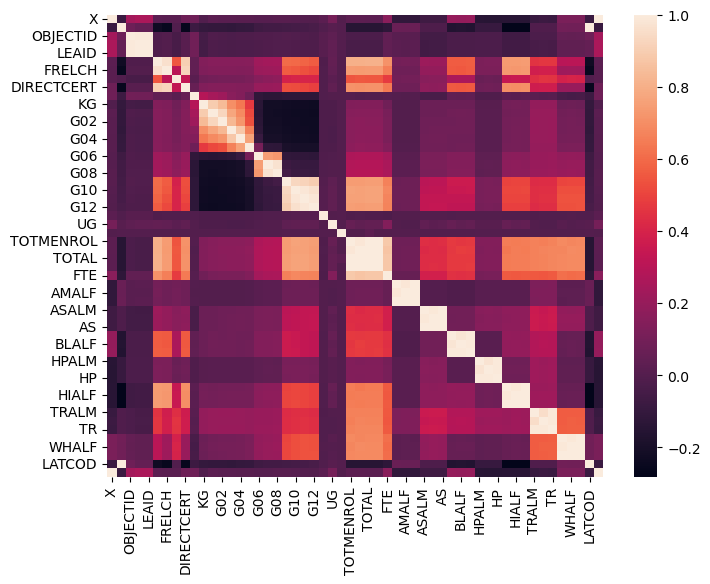

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation

target = "STUTERATIO"

# numeric columns only
num_df = s.select_dtypes(include="number")

# predictors only (exclude target for correlation test)
X = num_df.drop(columns=[target])


#Using Pearson Correlation
corrmat = X.corr()
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
sns.heatmap(corrmat)
# Compute correlation
# cor = num_df.corr()


def correlation(dataset, threshold=0.7):
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                
    return col_corr

corr_features = correlation(X, 0.7)

print("Dropping:", list(corr_features))


In [26]:
s.drop(corr_features,axis=1,inplace=True)


### 2.9 Data Shape After Cleaning

In [27]:
print("Shape after cleaning:", s.shape)
print("Total missing values remaining:", int(s.isna().sum().sum()))
s.columns


Shape after cleaning: (98910, 39)
Total missing values remaining: 0


Index(['X', 'Y', 'OBJECTID', 'SURVYEAR', 'STABR', 'ST_LEAID', 'LEA_NAME',
       'SCH_NAME', 'LSTREET1', 'LCITY', 'LSTATE', 'LZIP', 'PHONE', 'VIRTUAL',
       'GSLO', 'GSHI', 'SCHOOL_LEVEL', 'SCHOOL_TYPE_TEXT', 'SY_STATUS_TEXT',
       'ULOCALE', 'NMCNTY', 'TOTFRL', 'REDLCH', 'PK', 'KG', 'G06', 'G09',
       'G13', 'UG', 'AE', 'STUTERATIO', 'AMALM', 'ASALM', 'BLALM', 'HPALM',
       'TRALM', 'WHALM', 'TOTAL_RACE_CONS', 'TOTAL_GRADE_CONS'],
      dtype='object')

## Step 3: Normalization and Transformation

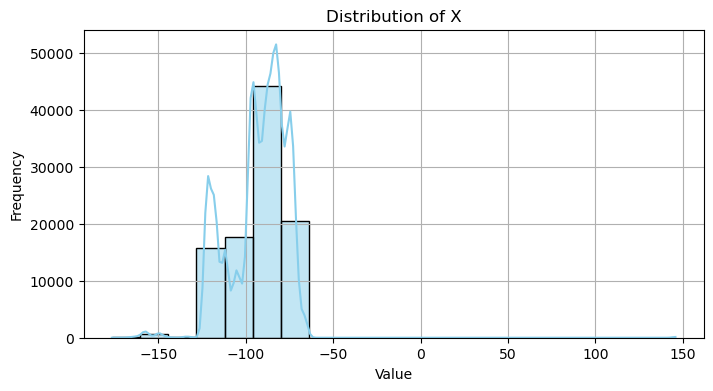

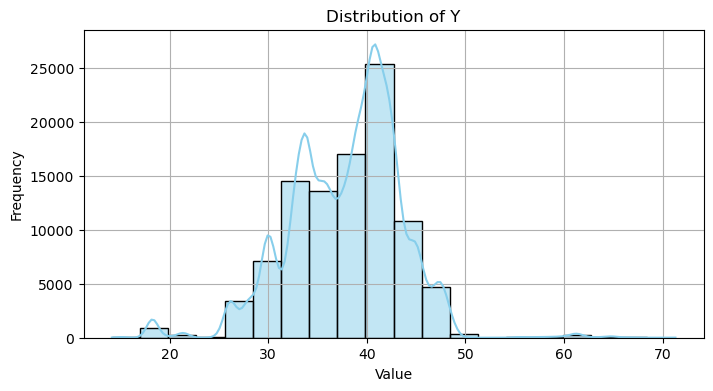

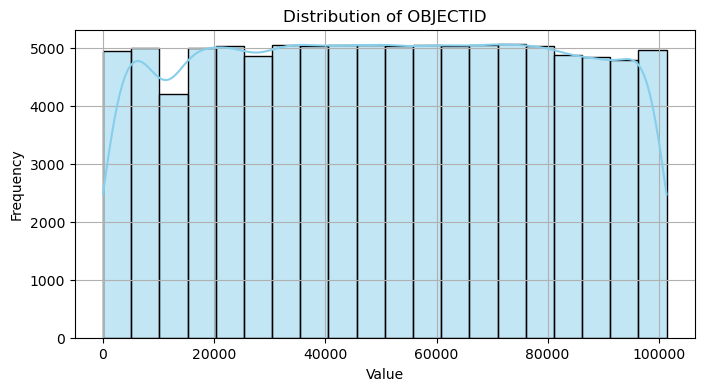

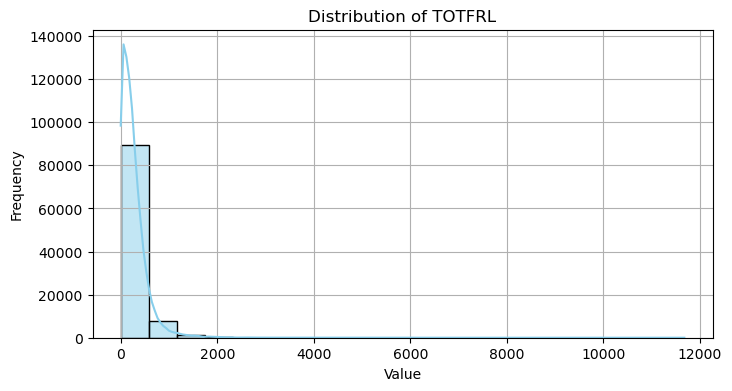

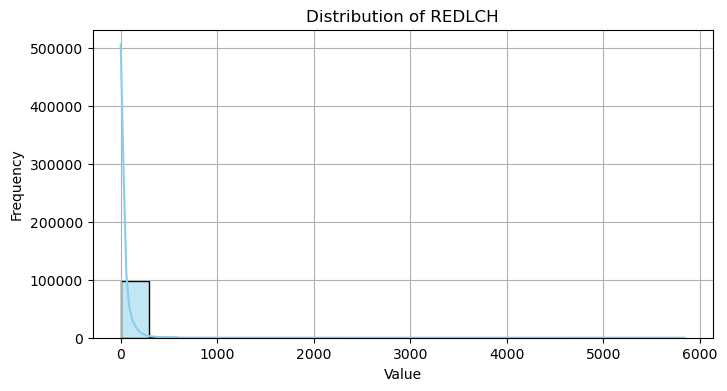

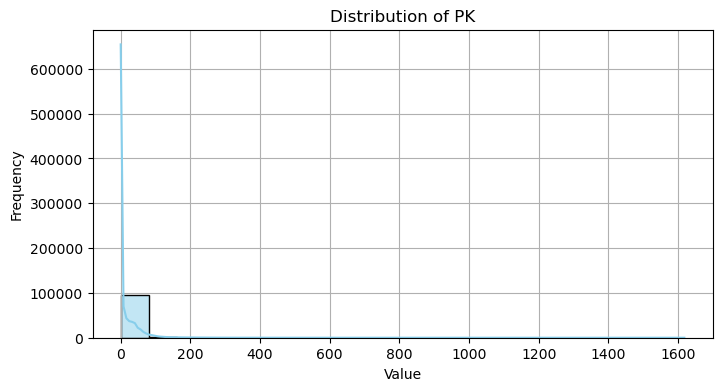

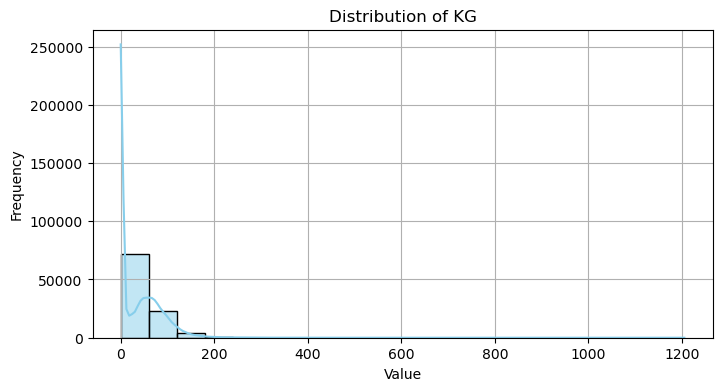

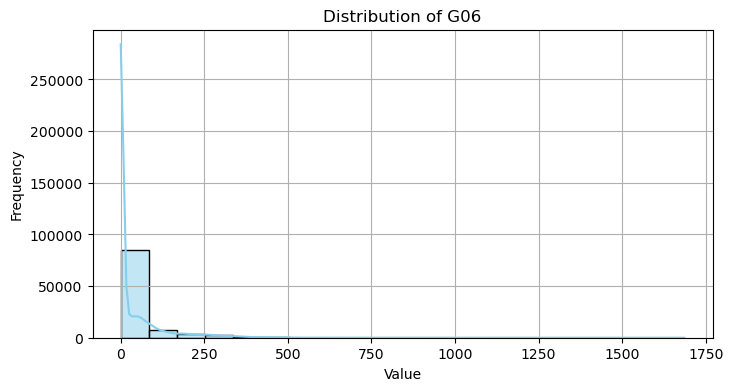

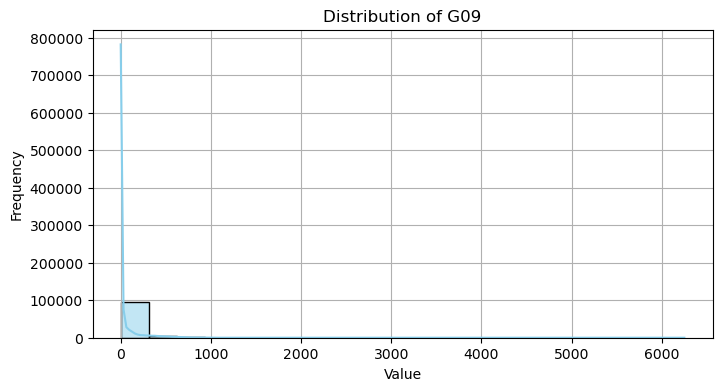

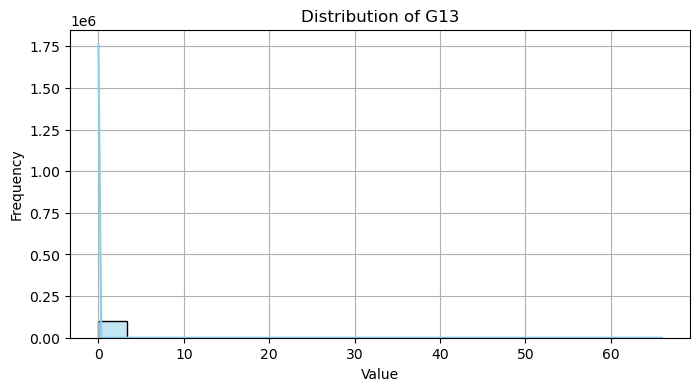

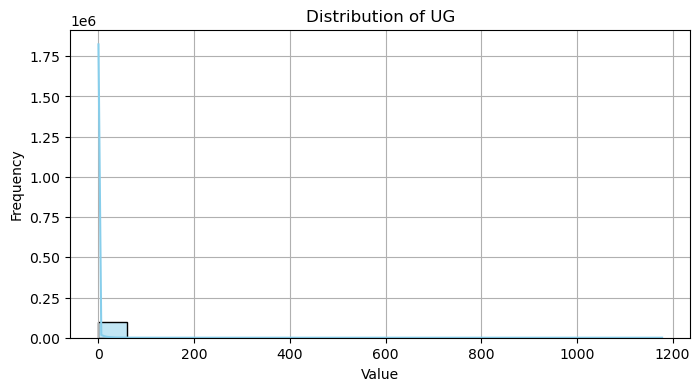

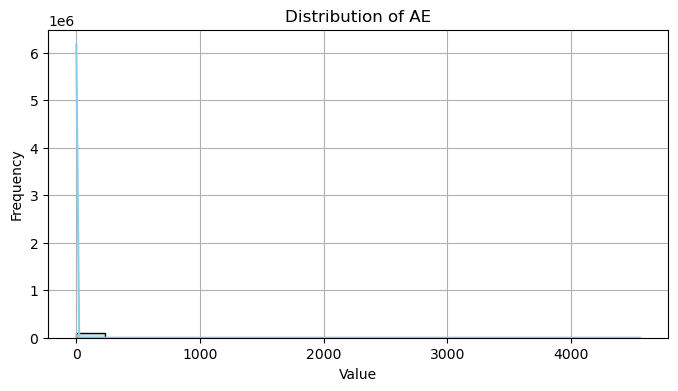

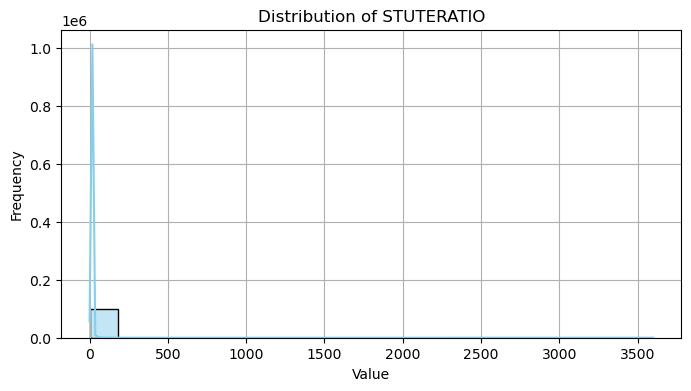

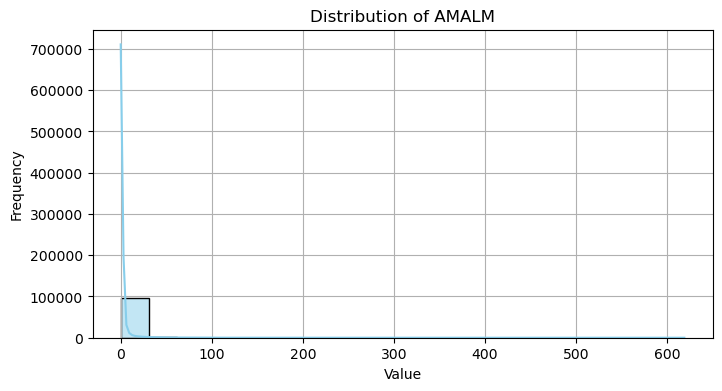

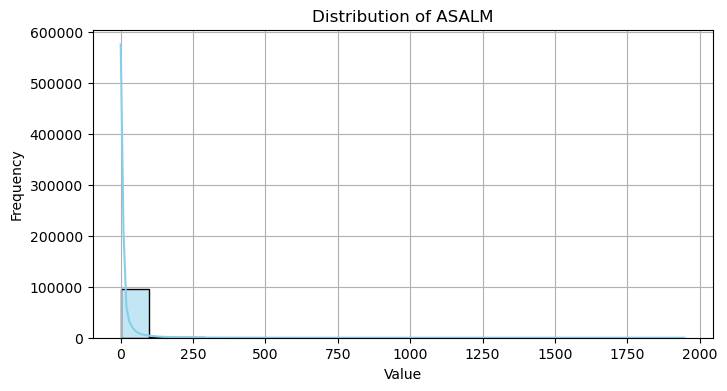

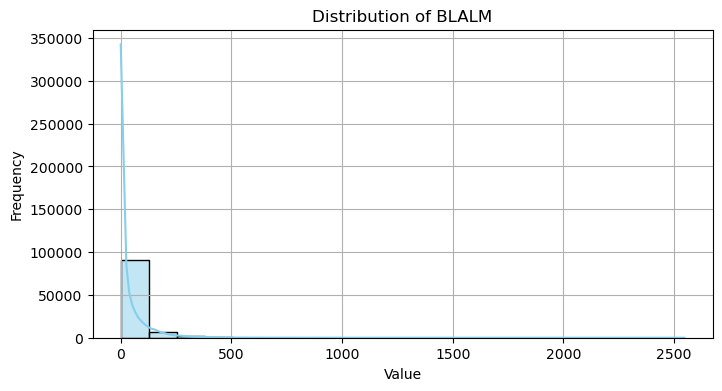

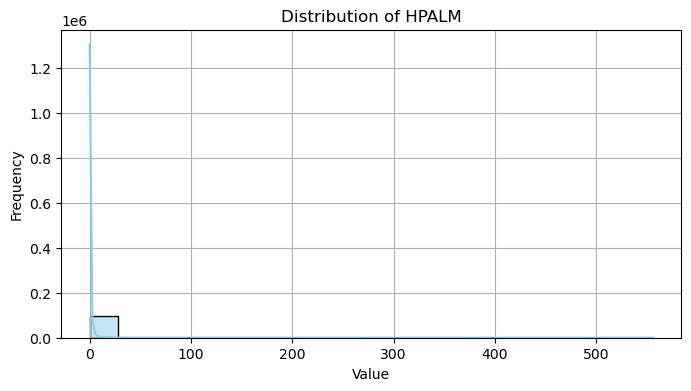

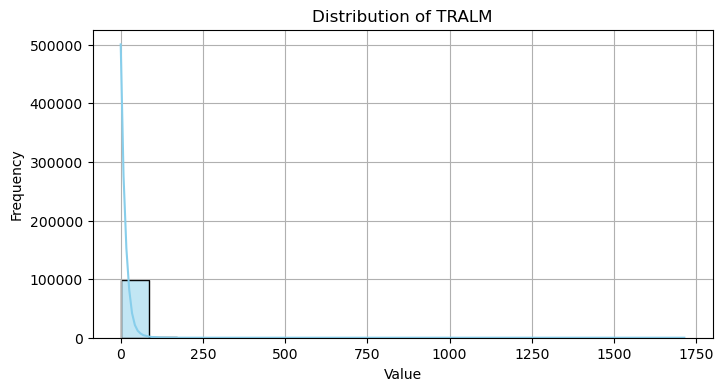

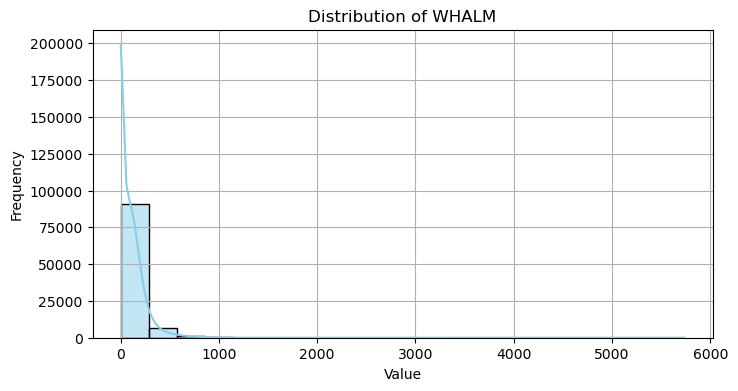

C:\Users\mktmo\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


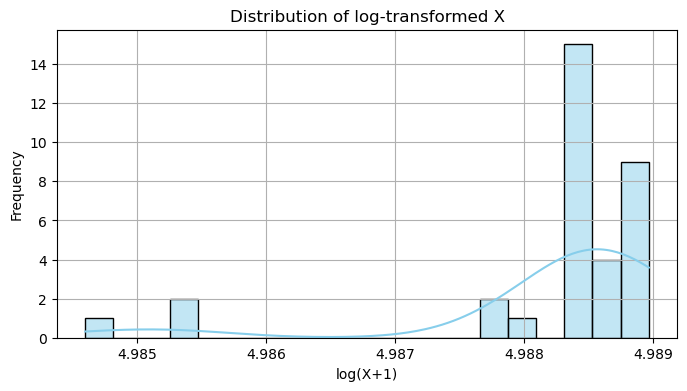

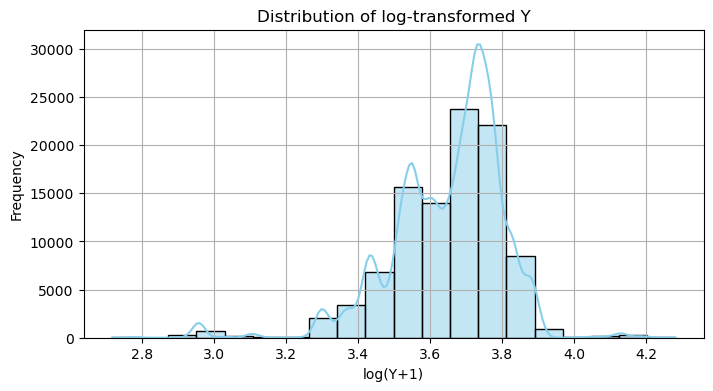

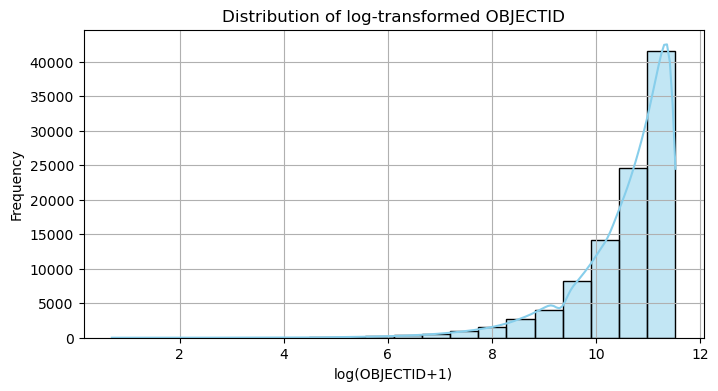

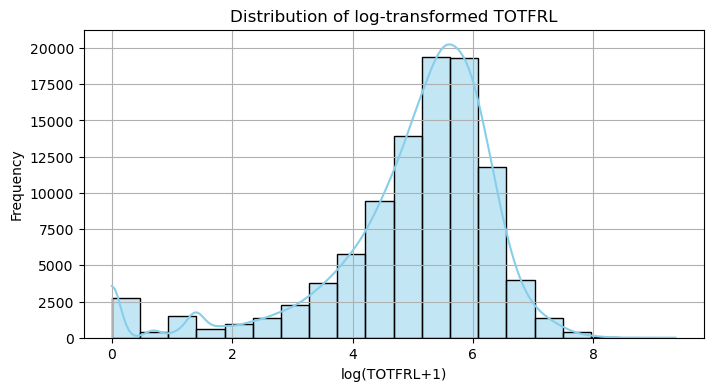

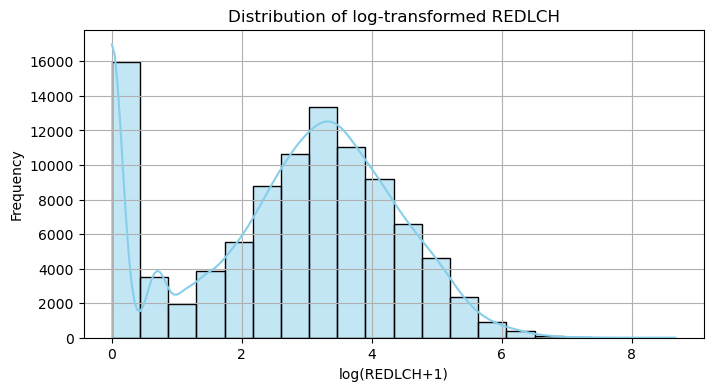

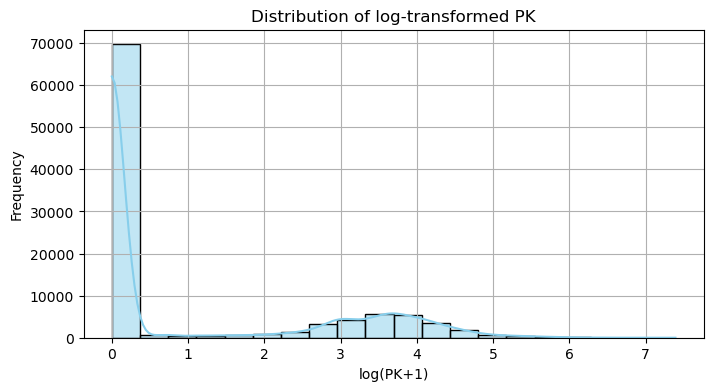

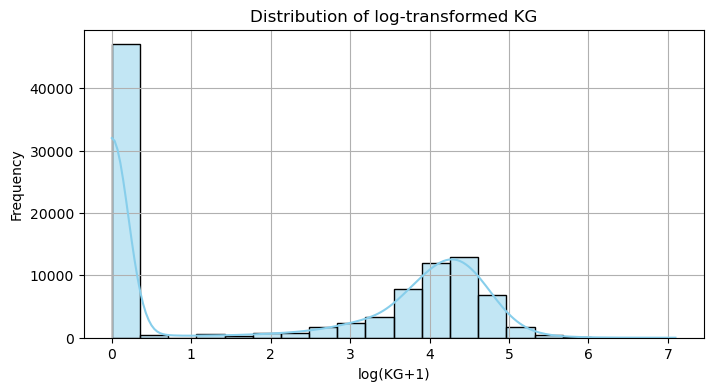

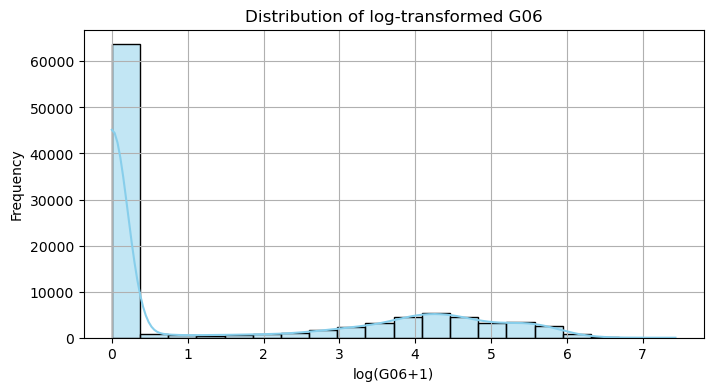

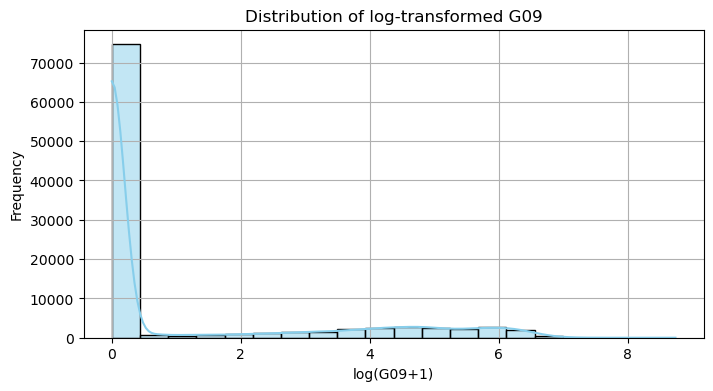

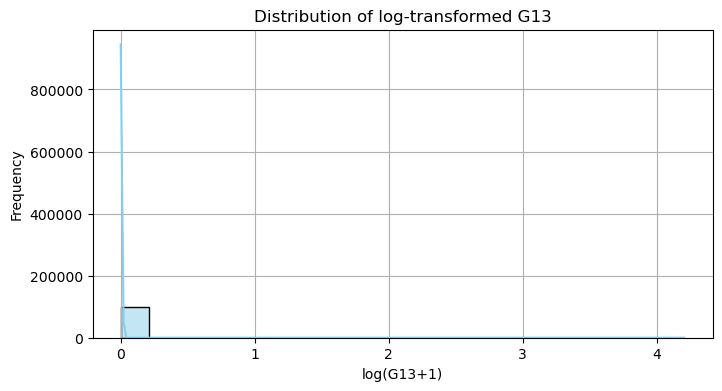

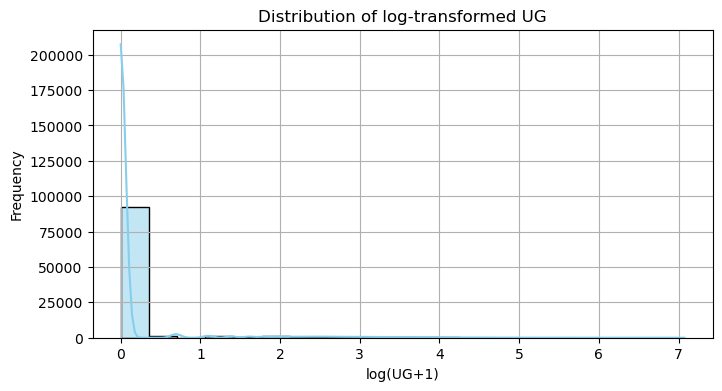

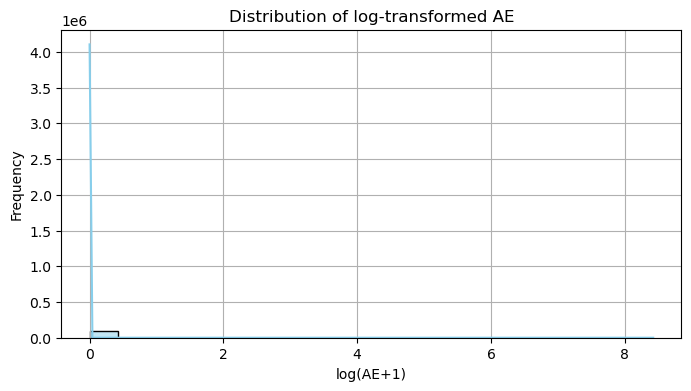

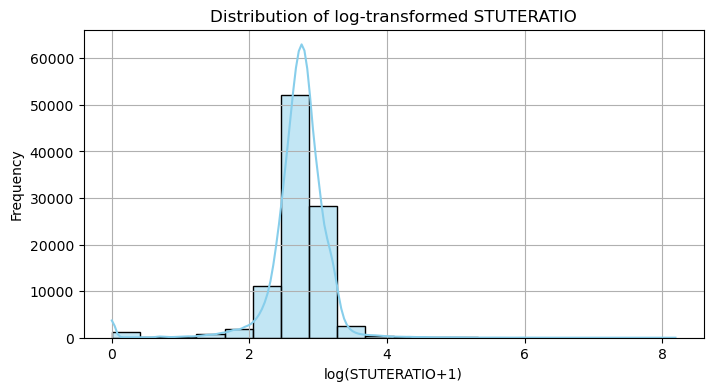

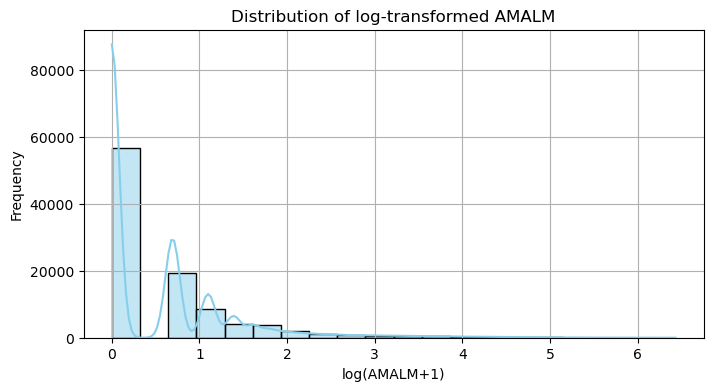

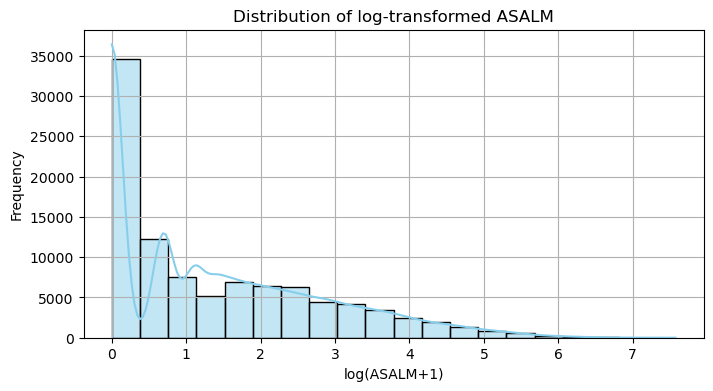

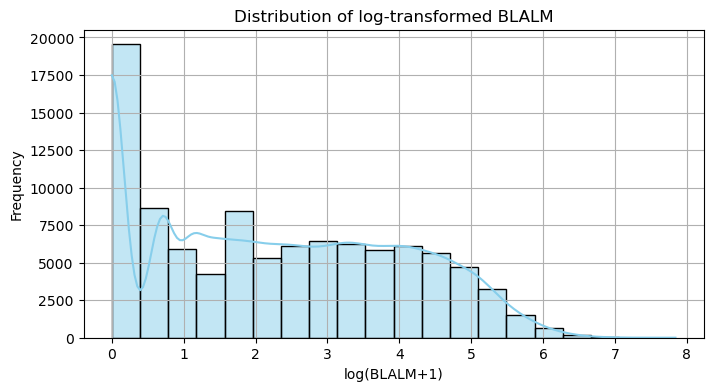

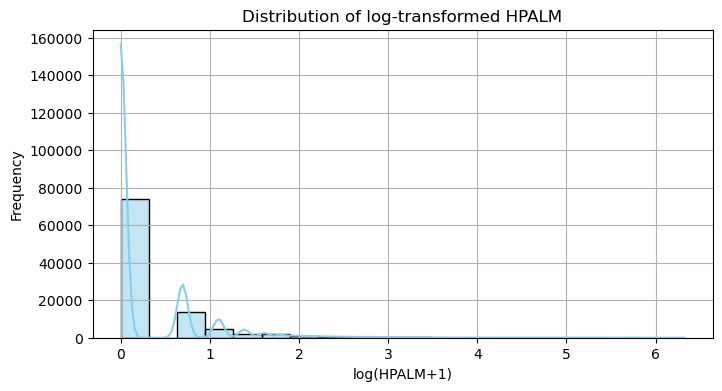

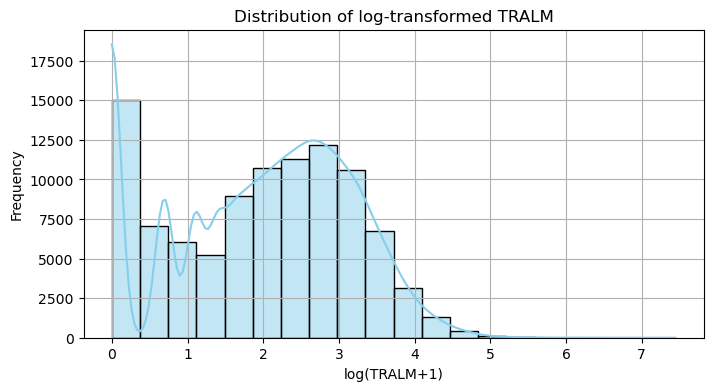

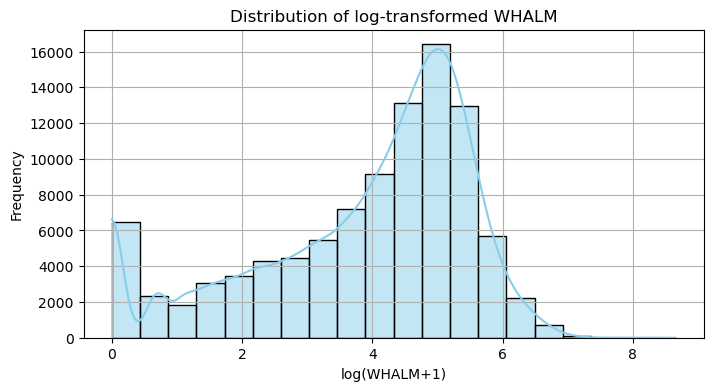

AE            149.640785
G13            35.186825
UG              4.758127
HPALM           2.911555
AMALM           2.187227
G09             1.595416
PK              1.163232
G06             0.899225
ASALM           0.890518
BLALM           0.224858
KG              0.081527
TRALM          -0.196839
REDLCH         -0.314527
WHALM          -0.881364
TOTFRL         -1.585766
STUTERATIO     -2.082348
dtype: float64


In [29]:
import matplotlib.pyplot as plt

# Transformation (log1p) for heavy-tailed count features to reduce skew

# Standardization (z-score) for continuous features used in modeling

# Select a few representative count features
# count_features = [c for c in ["TOTAL","FTE","TOTFRL"] if c in s.columns]
# for c in count_features:
#     s[f"LOG1P_{c}"] = np.log1p(s[c])

# # Standardize continuous features
# cont_features = [c for c in ["STUTERATIO","FRL_PCT","MINORITY_PCT","TOTAL","FTE"] if c in s.columns]
# for c in cont_features:
#     mean = s[c].mean()
#     std = s[c].std()
#     s[f"Z_{c}"] = (s[c] - mean) / std
num_df = s.select_dtypes(include="number")

for col in num_df:
    plt.figure(figsize=(8,4))
    
    sns.histplot(s[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show() 


for col in num_df:
    plt.figure(figsize=(8,4))
    
    # Apply log transformation, add 1 to avoid log(0)
    log_data = np.log1p(s[col])
    
    sns.histplot(log_data, bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of log-transformed {col}')
    plt.xlabel(f'log({col}+1)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

   
trans_cols = ["TOTFRL", "REDLCH", "PK", "KG", "G06", "G09", "G13", "UG", "AE", "STUTERATIO", "AMALM", "ASALM", "BLALM", "HPALM", "TRALM", "WHALM"]
s[trans_cols] = s[trans_cols].apply(lambda x: np.log1p(x))


### 3.1 Export Cleaned Dataset


In [ ]:
s.to_csv("Deliverable2_cleaned.csv", index=False)
print("Saved Deliverable2_cleaned_final.csv")
